<a href="https://colab.research.google.com/github/KagariET01/2024SpecAdmitNotifier/blob/main/scc_AI_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab1: Manual Logistic Regression & Titanic Survival Prediction

## Dataset Overview: The Titanic Dataset

This lab utilizes the classic Titanic dataset. It contains personal information of the passengers aboard the Titanic, which tragically sank in 1912. The goal is to build a predictive model to determine whether a passenger survived based on several input features.

### Feature Glossary:
* Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd).
* Sex: Gender of the passenger.
* Age: Age in years.
* SibSp: Number of siblings or spouses aboard.
* Parch: Number of parents or children aboard.
* Fare: Passenger fare (ticket price).
* Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).
* Survived: Survival status (0 = No, 1 = Yes) — this is our Target Label.

## Learning Objectives
The primary goal of this lab is to help students master the following machine learning concepts:
1. **Scikit-learn Pipelines**: Learn how to build an automated workflow using Pipeline and ColumnTransformer. This ensures that preprocessing steps (imputation, encoding, and scaling) are applied consistently to both training and validation sets, preventing Data Leakage.
2. **Feature Engineering & Interactions**: Understand how PolynomialFeatures can create "interaction terms" (e.g., Age $\times$ Sex). This allows a linear model like Logistic Regression to capture non-linear relationships.
3. **Algorithmic Implementation**: By writing the LogisticRegressionFull class from scratch, you will understand the mechanics of Gradient Descent, the Sigmoid function, and L2 Regularization (Weight Decay).
4. **Model Interpretability**: Learn to extract and analyze model weights to understand which features have the strongest positive or negative correlation with survival.

## How to Improve Accuracy?
If your model's accuracy is stagnant, consider adjusting the following components:
1. **Hyperparameter Tuning**
* **Learning Rate (lr)**: If the loss curve oscillates, decrease the lr. If it drops too slowly, increase it.
* **Iterations (iters)**: Increase the number of iterations if the loss has not yet flattened out.
* **Lambda ($\lambda$)**: This controls the L2 Regularization strength.
  * Increase $\lambda$ if the model is overfitting (high training accuracy, low validation accuracy).
  * Decrease $\lambda$ if the model is underfitting (low accuracy on both).
2. **Advanced Feature Engineering**
* **Polynomial Degree**: Change degree=2 to degree=3. This creates more complex feature combinations but increases the risk of overfitting.
* **Feature Selection**: Instead of using all features, try training the model only on the "Top 10" influential features to reduce noise.
* **Feature Creation**: Create a FamilySize feature by summing SibSp and Parch.
3. **Refined Imputation**
* Instead of using a simple global median for Age, try imputing missing ages based on the median age of a specific Pclass or Sex group for higher precision.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
# load dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = df['Survived'].values.reshape(-1, 1)

### Feature Preprocessing Steps
We categorize features into two groups to apply specific transformations:

**1. Numeric Features** (Age, SibSp, Parch, Fare)  
We use `SimpleImputer` with a `median` strategy to fill missing values.  
*(Note: Using the median is robust against outliers.)*

**2. Categorical Features** (Pclass, Sex, Embarked)  
We apply a two-step process:  
- **Imputation**: Fill missing values with the `most_frequent` (mode) value.  
- **Encoding**: Use `OneHotEncoder` to convert strings into binary vectors.

In [ ]:
numeric_features = [...]
categorical_features = [...]

# Try different strategies: 'mean', 'median', or 'most_frequent'
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='...'))
])

# handle_unknown='ignore' prevents crashes if a new category appears in test data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='...')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


### Feature Preprocessing & Pipeline Construction

We use a modular approach to handle different data types and prepare them for the model.

#### **A. Column Transformation**
The `ColumnTransformer` serves as a traffic controller, directing different columns to their specific processing steps:
* **Numeric Features**: Handles `Age`, `SibSp`, `Parch`, and `Fare` by filling missing values with the **median**.
* **Categorical Features**: Handles `Pclass`, `Sex`, and `Embarked` by filling missing values with the **mode** and then applying **One-Hot Encoding**.



#### **B. The Integrated Pipeline**
The `full_processor` combines multiple steps into a single object to ensure consistency between training and testing data:

1. **Preprocessing**: Cleans and encodes the raw data (Imputation + Encoding).
2. **Feature Engineering**: Uses `PolynomialFeatures` (degree=2) to create interaction terms (e.g., $Age \times Sex$), allowing the model to capture more complex patterns.
3. **Feature Scaling**: Uses `StandardScaler` to normalize the data.

> **Tip:** Scaling is essential for Logistic Regression. It ensures that the gradient descent process converges faster and that no single feature (like `Fare`) dominates others due to its numerical scale.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Try adjusting 'degree'
# Try using different scaler(e.g MinMaxScaler, StandardScaler)
full_processor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=..., include_bias=False)),
    ('scaler', ...)
])

### Data Splitting and Transformation

Before training, we must partition the data and apply our preprocessing pipeline.

#### **A. Dataset Splitting**
We use `train_test_split` to divide the dataset into two parts:
* **Training Set (80%)**: Used to "teach" the model and the preprocessor (calculating medians, means, and standard deviations).
* **Validation Set (20%)**: Used to evaluate the model's performance on unseen data.



#### **B. Applying the Pipeline (`fit_transform` vs. `transform`)**
This is a critical step to avoid **Data Leakage**:

1.  **`fit_transform` (Training Set)**:
    The pipeline "learns" the parameters from the training data (e.g., the median age or the mean of the fare) and then applies the transformation.
2.  **`transform` (Validation Set)**:
    We apply the **same** parameters learned from the training set to the validation set. We do *not* recalculate new medians or scales for the validation data, as this would be "cheating" by peeking at the test distribution.



> **Key Rule:** Never `fit` on your validation or test data. Always `fit` on the training data and simply `transform` the rest.

In [ ]:
# Challenge: You can try different test_size ratios (e.g., 0.1, 0.2, or 0.3)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_s = full_processor.fit_transform(X_train_raw)
X_val_s = full_processor.transform(X_val_raw)

### Manual Implementation of Logistic Regression

In this section, we implement the Logistic Regression algorithm from scratch to understand its optimization process.

#### **A. The Sigmoid Function**
The model uses the Sigmoid function to map any real-valued number into a probability between 0 and 1:
$$f(z) = \frac{1}{1 + e^{-z}}$$
* **Purpose**: It converts the linear output $z = Xw + b$ into a probability of belonging to the "Survived" class.
* **Clipping**: We use `np.clip` to prevent numerical overflow (exponential values becoming too large).


#### **B. Gradient Descent with L2 Regularization**
The `fit` method updates the weights ($w$) and bias ($b$) iteratively to minimize the loss.

**1. Gradient Calculation:**
The gradients represent the direction and magnitude of the steepest increase in loss.
* **$dw$**: The gradient for weights, including the **L2 Penalty** ($\frac{\lambda}{m}w$).
* **$db$**: The gradient for the bias.

**2. Weight Update Rule:**
We move in the opposite direction of the gradient to find the minimum:
$$w = w - learning\_rate \times dw$$
$$b = b - learning\_rate \times db$$



#### **C. Loss Function (Binary Cross-Entropy)**
To evaluate how well the model is performing, we calculate the Binary Cross-Entropy loss:
$$J = -\frac{1}{m} \sum [y \ln(\hat{y}) + (1-y) \ln(1-\hat{y})]$$
* We add a tiny value (`1e-15`) to the logarithms to prevent calculating $\ln(0)$, which is undefined.

In [ ]:
class LogisticRegressionFull:
    def __init__(self, lr=0.01, iters=5000, lambd=0.5):
        self.lr = lr
        self.iters = iters
        self.lambd = lambd
        self.weights = None
        self.bias = 0
        self.train_losses = []
        self.val_losses = []

    def sigmoid(self, z):
        # Implement the Sigmoid function formula: 1 / (1 + e^-z)
        # Hint: Use np.exp(). np.clip is used here to prevent overflow errors.
        return ### YOUR CODE HERE ###

    def fit(self, X, y, X_val, y_val):
        m, n = X.shape
        self.weights = np.zeros((n, 1))

        for i in range(self.iters):
            # Forward Pass: Compute the linear combination
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            # Compute Gradients with L2 Regularization
            # Formulas:
            # dw = (1/m) * X^T * (y_pred - y) + (lambd/m) * weights
            # db = (1/m) * sum(y_pred - y)
            dw = ### YOUR CODE HERE ###
            db = ### YOUR CODE HERE ###

            # Update Weights and Bias using Gradient Descent
            # Formula: parameter = parameter - learning_rate * gradient
            self.weights -= ### YOUR CODE HERE ###
            self.bias -= ### YOUR CODE HERE ###

            # Recording losses for visualization
            loss = -np.mean(y * np.log(y_pred + 1e-15) + (1-y) * np.log(1 - y_pred + 1e-15))
            self.train_losses.append(loss)

            val_pred = self.sigmoid(np.dot(X_val, self.weights) + self.bias)
            v_loss = -np.mean(y_val * np.log(val_pred + 1e-15) + (1-y_val) * np.log(1 - val_pred + 1e-15))
            self.val_losses.append(v_loss)

    def predict(self, X):
        return (self.sigmoid(np.dot(X, self.weights) + self.bias) >= 0.5).astype(int)

### Model Training & Parameter Initialization

Now that our data is prepared and our class is defined, we instantiate the model and begin the optimization process.

#### **A. Initializing the Model**
We create an instance of `LogisticRegressionFull` with the following default or custom settings:
* **`lr=0.01` (Learning Rate)**: Determines how much we adjust the weights in each step.
* **`iters=5000`**: The model will iterate through the entire training set 5,000 times to minimize the loss.
* **`lambd=0.5`**: This is the L2 regularization coefficient used to prevent the weights from growing too large.



#### **B. The Training Process (`fit` method)**
When we call `model.fit(X_train_s, y_train, X_val_s, y_val)`, the following happens:
1.  **Weight Initialization**: Weights are set to zero.
2.  **Forward Pass**: The model calculates predictions using the current weights.
3.  **Loss Calculation**: It calculates the error (Binary Cross-Entropy) for both training and validation sets.
4.  **Backward Pass (Gradient Descent)**: It calculates the gradients and updates the weights to reduce the error.



> **Why provide `X_val` during training?** > Even though the model doesn't "learn" from the validation set, we pass it into the `fit` method so we can monitor the **Validation Loss** in real-time. This helps us detect if the model is starting to overfit (where Train Loss goes down but Val Loss goes up).

In [ ]:
model = LogisticRegressionFull()
model.fit(X_train_s, y_train, X_val_s, y_val)

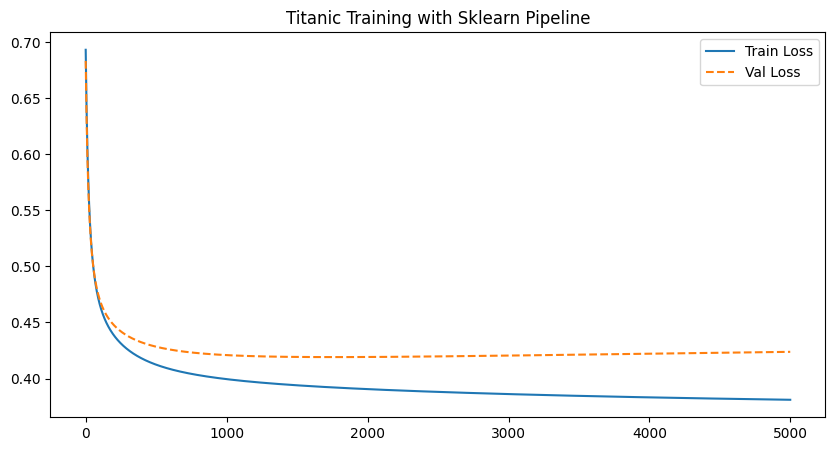

Training set accuracy: 0.8385
Validation set accuracy: 0.8268

 [Top 10 Feature Importance]
Age Sex_male                       : -0.4437
Age Parch                          : -0.4290
Pclass_2 Sex_female                : 0.4165
Age Sex_female                     : 0.3340
Parch Embarked_Q                   : -0.3026
Parch Fare                         : -0.2928
SibSp Pclass_1                     : 0.2721
Pclass_2 Sex_male                  : -0.2707
Parch Sex_male                     : 0.2706
Fare Pclass_3                      : 0.2700


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Val Loss', linestyle='--')
plt.title("Titanic Training with Sklearn Pipeline")
plt.legend()
plt.show()

print(f"Training set accuracy: {accuracy_score(y_train, model.predict(X_train_s)):.4f}")
print(f"Validation set accuracy: {accuracy_score(y_val, model.predict(X_val_s)):.4f}")

poly_names = full_processor.named_steps['poly'].get_feature_names_out(
    full_processor.named_steps['preprocessor'].get_feature_names_out()
)
weights = model.weights.flatten()
idx = np.argsort(np.abs(weights))[::-1]

print("\n [Top 10 Feature Importance]")
for i in range(10):
    name = poly_names[idx[i]].replace('num__', '').replace('cat__', '')
    print(f"{name:35s}: {weights[idx[i]]:.4f}")

## Critical Thinking

1. Why does the interaction term Age $\times$ Sex_male usually result in a significant negative weight?

2. Why does the interaction term Pclass_2 $\times$ Sex_female usually result in a significant positive weight?